<a href="https://colab.research.google.com/github/DennisWayo/Nordgren-FracSim/blob/main/nordgren_pinn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN code for Nordgren Frac Model

## Adam + L-BFGS + NNCG

Adam Epoch 0, Loss: 0.3971322178840637
Adam Epoch 100, Loss: 4.713888847618364e-05
Adam Epoch 200, Loss: 1.6560917970309674e-08
Adam Epoch 300, Loss: 1.6322450946404388e-08
Adam Epoch 400, Loss: 1.6070730524120336e-08
Adam Epoch 500, Loss: 1.5782987361490086e-08
Adam Epoch 600, Loss: 1.54683359454566e-08
Adam Epoch 700, Loss: 1.5134700603880447e-08
Adam Epoch 800, Loss: 1.4786907698294272e-08
Adam Epoch 900, Loss: 1.4430062478254513e-08
NNCG step completed
Total Memory Used: 793.92 MB
Total Time Elapsed: 1056.11 seconds


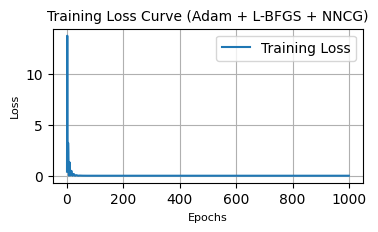

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


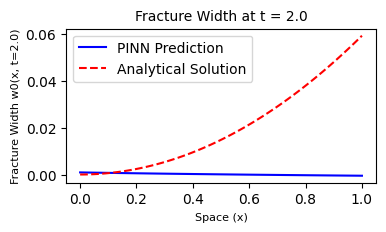

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


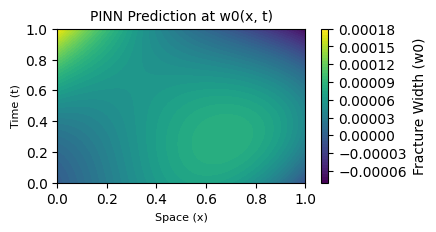

In [ ]:
import time
import psutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to track memory usage
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 ** 2  # Convert to MB

# Tracking time and memory
start_time = time.time()
start_memory = memory_usage()

# Define constants
E_prime = 30.0  # Young's modulus (E')
mu = 5.0  # Viscosity (mu)
H = 1.0  # Height (H)
C_L = 0.0  # Leak-off coefficient (C_L)
t_0 = 0.0  # Initial time (t_0)

# Neural network architecture
input_x = tf.keras.layers.Input(shape=(1,), name="x")
input_t = tf.keras.layers.Input(shape=(1,), name="t")
inputs = tf.keras.layers.Concatenate()([input_x, input_t])

x = tf.keras.layers.Dense(256, activation="tanh")(inputs)
x = tf.keras.layers.Dense(256, activation="tanh")(x)
x = tf.keras.layers.Dense(256, activation="tanh")(x)
x = tf.keras.layers.Dense(256, activation="tanh")(x)
output = tf.keras.layers.Dense(1, activation=None)(x)

model = tf.keras.Model(inputs=[input_x, input_t], outputs=output)

# Loss functions
def loss_function(x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        w0 = model([x, t])
        w0_t = tape.gradient(w0, t)
        w0_x = tape.gradient(w0, x)
        w0_xx = tape.gradient(w0_x, x)
    residuals = (E_prime / (128 * mu * H)) * w0_xx - w0_t
    del tape
    return tf.reduce_mean(tf.square(residuals))

def boundary_loss(x_boundary, t_boundary, w_boundary):
    w_pred = model([x_boundary, t_boundary])
    return tf.reduce_mean(tf.square(w_pred - w_boundary))

lambda_bc = 30.0
def total_loss(x, t, x_boundary, t_boundary, w_boundary):
    physics_loss = loss_function(x, t)
    bc_loss = boundary_loss(x_boundary, t_boundary, w_boundary)
    return physics_loss + lambda_bc * bc_loss

# Collocation points
num_points = 5000
x_collocation = tf.random.uniform((num_points, 1), minval=0.0, maxval=1.0)
t_collocation = tf.random.uniform((num_points, 1), minval=0.0, maxval=1.0)

# Boundary points
x_boundary = tf.constant([[0.0], [1.0]])
t_boundary = tf.random.uniform((2, 1), minval=0.0, maxval=1.0)
w_boundary = tf.constant([[0.0], [0.0]])

# Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Adam Training
epochs_adam = 1000
adam_loss_history = []

for epoch in range(epochs_adam):
    with tf.GradientTape() as tape:
        loss = total_loss(x_collocation, t_collocation, x_boundary, t_boundary, w_boundary)
    gradients = tape.gradient(loss, model.trainable_variables)
    adam_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    adam_loss_history.append(loss.numpy())
    if epoch % 100 == 0:
        print(f"Adam Epoch {epoch}, Loss: {loss.numpy()}")


# L-BFGS Optimization
initial_vars = np.concatenate([v.numpy().flatten() for v in model.trainable_variables])

def lbfgs_loss_and_grads(flattened_vars):
    start = 0
    for var in model.trainable_variables:
        shape = tf.shape(var)
        size = tf.reduce_prod(shape)
        new_value = tf.reshape(flattened_vars[start:start + size], shape)
        var.assign(new_value)
        start += size
    with tf.GradientTape() as tape:
        loss = total_loss(x_collocation, t_collocation, x_boundary, t_boundary, w_boundary)
    grads = tape.gradient(loss, model.trainable_variables)
    flattened_grads = np.concatenate([g.numpy().flatten() for g in grads])
    return loss.numpy(), flattened_grads

lbfgs_result = minimize(
    fun=lambda vars: lbfgs_loss_and_grads(vars)[0],
    jac=lambda vars: lbfgs_loss_and_grads(vars)[1],
    x0=initial_vars,
    method="L-BFGS-B",
    callback=lambda xk: print("L-BFGS step completed")
)

# Newton-CG Optimization
def nncg_loss(flattened_vars):
    start = 0
    for var in model.trainable_variables:
        shape = tf.shape(var)
        size = tf.reduce_prod(shape)
        new_value = tf.reshape(flattened_vars[start:start + size], shape)
        var.assign(new_value)
        start += size
    return total_loss(x_collocation, t_collocation, x_boundary, t_boundary, w_boundary).numpy()

def nncg_jac(flattened_vars):
    start = 0
    for var in model.trainable_variables:
        shape = tf.shape(var)
        size = tf.reduce_prod(shape)
        new_value = tf.reshape(flattened_vars[start:start + size], shape)
        var.assign(new_value)
        start += size
    with tf.GradientTape() as tape:
        loss = total_loss(x_collocation, t_collocation, x_boundary, t_boundary, w_boundary)
    grads = tape.gradient(loss, model.trainable_variables)
    return np.concatenate([g.numpy().flatten() for g in grads])

nncg_result = minimize(
    fun=nncg_loss,
    jac=nncg_jac,
    x0=lbfgs_result.x,
    method="Newton-CG",
    callback=lambda xk: print("NNCG step completed")
)

# Stop tracking time and memory after all computations
end_time = time.time()
end_memory = memory_usage()

# Print resource usage
print(f"Total Memory Used: {end_memory - start_memory:.2f} MB")
print(f"Total Time Elapsed: {end_time - start_time:.2f} seconds")

# Training Loss Plot
plt.figure(figsize=(4, 2))
plt.plot(range(epochs_adam), adam_loss_history, label="Training Loss")
plt.xlabel("Epochs", fontsize = 8)
plt.ylabel("Loss", fontsize = 8)
plt.title("Training Loss Curve (Adam + L-BFGS + NNCG)", fontsize = 10)
plt.legend()
plt.grid(True)
plt.show()

# Analytical vs PINN comparison at fixed time
t_fixed = 2.0
x_fixed = np.linspace(0, 1, 100)[:, None]
t_fixed_array = np.full_like(x_fixed, t_fixed)

# Predictions
w0_fixed_pred = model.predict([x_fixed, t_fixed_array])
w0_analytical_fixed = (E_prime / (128 * mu * H)) * (x_fixed**2) * (t_fixed**(1/3))

plt.figure(figsize=(4, 2))
plt.plot(x_fixed, w0_fixed_pred, label="PINN Prediction", color="blue")
plt.plot(x_fixed, w0_analytical_fixed, label="Analytical Solution", linestyle="dashed", color="red")
plt.xlabel("Space (x)", fontsize = 8)
plt.ylabel(f"Fracture Width w0(x, t={t_fixed})", fontsize = 8)
plt.title(f"Fracture Width at t = {t_fixed}", fontsize = 10)
plt.legend()
plt.show()

# Contour plot of PINN prediction
x_vals = np.linspace(0, 1, 100)
t_vals = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_vals, t_vals)
x_flat = X.flatten()[:, None]
t_flat = T.flatten()[:, None]

w0_pred = model.predict([x_flat, t_flat])
W0 = w0_pred.reshape(X.shape)

plt.figure(figsize=(4, 2))
contour = plt.contourf(X, T, W0, levels=50, cmap="viridis")
plt.colorbar(contour, label="Fracture Width (w0)")
plt.xlabel("Space (x)", fontsize = 8)
plt.ylabel("Time (t)", fontsize = 8)
plt.title("PINN Prediction at w0(x, t)", fontsize = 10)
plt.show()

## Adam + L-BFGS

Adam Epoch 0, Loss: 0.23582886159420013
Adam Epoch 100, Loss: 2.324832348676864e-05
Adam Epoch 200, Loss: 2.1424723328777873e-08
Adam Epoch 300, Loss: 2.1219699775087975e-08
Adam Epoch 400, Loss: 2.110105867814127e-08
Adam Epoch 500, Loss: 2.0962634295074167e-08
Adam Epoch 600, Loss: 2.0808279543871322e-08
Adam Epoch 700, Loss: 2.064251525268901e-08
Adam Epoch 800, Loss: 2.0465758865384487e-08
Adam Epoch 900, Loss: 2.0279674828316274e-08
Total Memory Used: 344.38 MB
Total Time Elapsed: 724.56 seconds


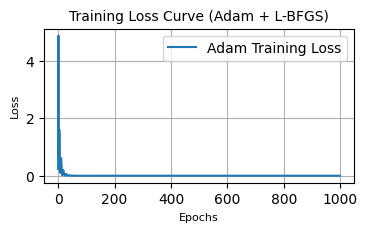

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


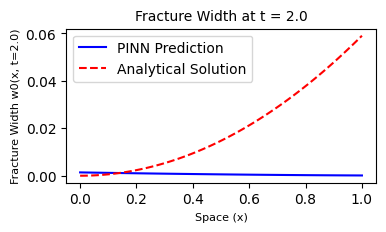

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


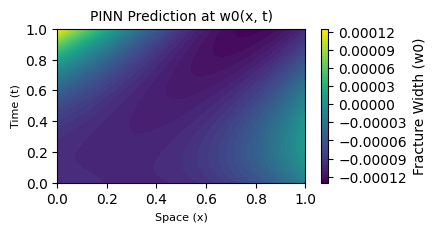

In [ ]:
import time
import psutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to track memory usage
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 ** 2  # Convert to MB

# Tracking time and memory
start_time = time.time()
start_memory = memory_usage()

# Define constants
E_prime = 30.0  # Young's modulus (E')
mu = 5.0  # Viscosity (mu)
H = 1.0  # Height (H)
C_L = 0.0  # Leak-off coefficient (C_L)
t_0 = 0.0  # Initial time (t_0)

# Neural network architecture
input_x = tf.keras.layers.Input(shape=(1,), name="x")
input_t = tf.keras.layers.Input(shape=(1,), name="t")
inputs = tf.keras.layers.Concatenate()([input_x, input_t])

# Improved architecture
x = tf.keras.layers.Dense(256, activation="tanh")(inputs)
x = tf.keras.layers.Dense(256, activation="tanh")(x)
x = tf.keras.layers.Dense(256, activation="tanh")(x)
output = tf.keras.layers.Dense(1, activation=None)(x)

# Build the model
model = tf.keras.Model(inputs=[input_x, input_t], outputs=output)

# Loss function for the Nordgren PDE
def loss_function(x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        w0 = model([x, t])

        # Compute gradients
        w0_t = tape.gradient(w0, t)
        w0_x = tape.gradient(w0, x)
        w0_xx = tape.gradient(w0_x, x)

    # Residual based on the Nordgren PDE
    residuals = (E_prime / (128 * mu * H)) * w0_xx - w0_t
    del tape  # Release resources
    return tf.reduce_mean(tf.square(residuals))

# Boundary loss
def boundary_loss(x_boundary, t_boundary, w_boundary):
    w_pred = model([x_boundary, t_boundary])
    return tf.reduce_mean(tf.square(w_pred - w_boundary))

# Total loss with reweighting
lambda_bc = 30.0  # Weight for boundary conditions
def total_loss(x, t, x_boundary, t_boundary, w_boundary):
    physics_loss = loss_function(x, t)
    bc_loss = boundary_loss(x_boundary, t_boundary, w_boundary)
    return physics_loss + lambda_bc * bc_loss

# Generate collocation points
num_points = 5000
x_collocation = tf.random.uniform((num_points, 1), minval=0.0, maxval=1.0)
t_collocation = tf.random.uniform((num_points, 1), minval=0.0, maxval=1.0)

# Boundary points
x_boundary = tf.constant([[0.0], [1.0]])
t_boundary = tf.random.uniform((2, 1), minval=0.0, maxval=1.0)
w_boundary = tf.constant([[0.0], [0.0]])

# Adam optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=500, decay_rate=0.9
)
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# L-BFGS optimization: Prepare loss and gradient functions
def lbfgs_loss_and_grads(flattened_vars):
    # Map flattened variables back to model's trainable variables
    start = 0
    for var in model.trainable_variables:
        shape = tf.shape(var)
        size = tf.reduce_prod(shape)
        new_value = tf.reshape(flattened_vars[start:start + size], shape)
        var.assign(new_value)
        start += size

    # Compute loss and gradients
    with tf.GradientTape() as tape:
        loss = total_loss(x_collocation, t_collocation, x_boundary, t_boundary, w_boundary)
    grads = tape.gradient(loss, model.trainable_variables)

    # Flatten gradients for scipy optimizer
    flattened_grads = np.concatenate([g.numpy().flatten() for g in grads])
    return loss.numpy(), flattened_grads

# Adam Training Loop
epochs_adam = 1000
adam_loss_history = []

for epoch in range(epochs_adam):
    with tf.GradientTape() as tape:
        loss = total_loss(x_collocation, t_collocation, x_boundary, t_boundary, w_boundary)
    gradients = tape.gradient(loss, model.trainable_variables)
    adam_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    adam_loss_history.append(loss.numpy())

    if epoch % 100 == 0:
        print(f"Adam Epoch {epoch}, Loss: {loss.numpy()}")

# L-BFGS Optimization
initial_vars = np.concatenate([v.numpy().flatten() for v in model.trainable_variables])

lbfgs_result = minimize(
    fun=lambda vars: lbfgs_loss_and_grads(vars)[0],
    jac=lambda vars: lbfgs_loss_and_grads(vars)[1],
    x0=initial_vars,
    method="L-BFGS-B",
    callback=lambda xk: print("L-BFGS step completed")
)

# Map optimized variables back to the model
start = 0
for var in model.trainable_variables:
    shape = tf.shape(var)
    size = tf.reduce_prod(shape)
    new_value = tf.reshape(lbfgs_result.x[start:start + size], shape)
    var.assign(new_value)
    start += size


# Stop tracking time and memory after all computations
end_time = time.time()
end_memory = memory_usage()

# Print resource usage
print(f"Total Memory Used: {end_memory - start_memory:.2f} MB")
print(f"Total Time Elapsed: {end_time - start_time:.2f} seconds")


# Plot training loss
plt.figure(figsize=(4, 2))
plt.plot(range(epochs_adam), adam_loss_history, label="Adam Training Loss")
plt.xlabel("Epochs", fontsize = 8)
plt.ylabel("Loss", fontsize = 8)
plt.title("Training Loss Curve (Adam + L-BFGS)", fontsize = 10)
plt.legend()
plt.grid(True)
plt.show()

# Analytical vs PINN comparison at fixed time
t_fixed = 2.0
x_fixed = np.linspace(0, 1, 100)[:, None]
t_fixed_array = np.full_like(x_fixed, t_fixed)

# Predictions
w0_fixed_pred = model.predict([x_fixed, t_fixed_array])
w0_analytical_fixed = (E_prime / (128 * mu * H)) * (x_fixed**2) * (t_fixed**(1/3))

plt.figure(figsize=(4, 2))
plt.plot(x_fixed, w0_fixed_pred, label="PINN Prediction", color="blue")
plt.plot(x_fixed, w0_analytical_fixed, label="Analytical Solution", linestyle="dashed", color="red")
plt.xlabel("Space (x)", fontsize = 8)
plt.ylabel(f"Fracture Width w0(x, t={t_fixed})", fontsize = 8)
plt.title(f"Fracture Width at t = {t_fixed}", fontsize = 10)
plt.legend()
plt.show()


# Contour plot of PINN prediction
x_vals = np.linspace(0, 1, 100)
t_vals = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_vals, t_vals)
x_flat = X.flatten()[:, None]
t_flat = T.flatten()[:, None]

w0_pred = model.predict([x_flat, t_flat])
W0 = w0_pred.reshape(X.shape)

plt.figure(figsize=(4, 2))
contour = plt.contourf(X, T, W0, levels=50, cmap="viridis")
plt.colorbar(contour, label="Fracture Width (w0)")
plt.xlabel("Space (x)", fontsize = 8)
plt.ylabel("Time (t)", fontsize = 8)
plt.title("PINN Prediction at w0(x, t)", fontsize = 10)
plt.show()

## Adam

In [ ]:
import time
import psutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to track memory usage
def memory_usage():
    process = psutil.Process()
    return process.memory_info().rss / 1024 ** 2  # Convert to MB

# Tracking time and memory
start_time = time.time()
start_memory = memory_usage()

# Define constants
E_prime = 30.0  # Young's modulus (E')
mu = 5.0  # Viscosity (mu)
H = 1.0  # Height (H)
C_L = 0.0  # Leak-off coefficient (C_L)
t_0 = 0.0  # Initial time (t_0)

# Neural network architecture with boundary condition enforcement
input_x = tf.keras.layers.Input(shape=(1,), name="x")
input_t = tf.keras.layers.Input(shape=(1,), name="t")
inputs = tf.keras.layers.Concatenate()([input_x, input_t])

# Improved architecture
x = tf.keras.layers.Dense(256, activation="tanh")(inputs)
x = tf.keras.layers.Dense(256, activation="tanh")(x)
x = tf.keras.layers.Dense(256, activation="tanh")(x)
nn_output = tf.keras.layers.Dense(1, activation=None)(x)

# Enforce boundary conditions: w0(x, t) = x * (1 - x) * NN(x, t)
output = tf.keras.layers.Multiply()([input_x * (1 - input_x), nn_output])

# Build the model
model = tf.keras.Model(inputs=[input_x, input_t], outputs=output)

# Loss function for the Nordgren PDE
def loss_function(x, t):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        w0 = model([x, t])

        # Compute gradients
        w0_t = tape.gradient(w0, t)
        w0_x = tape.gradient(w0, x)
        w0_xx = tape.gradient(w0_x, x)

    # Residual based on the Nordgren PDE
    residuals = (E_prime / (128 * mu * H)) * w0_xx - w0_t
    del tape  # Release resources
    return tf.reduce_mean(tf.square(residuals))

# Optimizer
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=500, decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Training step
def train_step(x, t):
    with tf.GradientTape() as tape:
        loss = loss_function(x, t)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Generate collocation points
num_points = 5000
x_collocation = tf.random.uniform((num_points, 1), minval=0.0, maxval=1.0)
t_collocation = tf.random.uniform((num_points, 1), minval=0.0, maxval=1.0)

# Training loop
epochs = 1000
loss_history = []

for epoch in range(epochs):
    # Compute total loss and update weights
    loss = train_step(x_collocation, t_collocation)
    loss_history.append(loss.numpy())

    # Log loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")


# Stop tracking time and memory after all computations
end_time = time.time()
end_memory = memory_usage()

# Print resource usage
print(f"Total Memory Used: {end_memory - start_memory:.2f} MB")
print(f"Total Time Elapsed: {end_time - start_time:.2f} seconds")


# Plot training loss
plt.figure(figsize=(4, 2))
plt.plot(range(epochs), loss_history, label="Training Loss")
plt.xlabel("Epochs", fontsize = 8)
plt.ylabel("Loss", fontsize = 8)
plt.title("Adam", fontsize = 10)
plt.legend()
plt.grid(True)
plt.show()

# Analytical vs PINN comparison at fixed time
t_fixed = 2.0
x_fixed = np.linspace(0, 1, 100)[:, None]
t_fixed_array = np.full_like(x_fixed, t_fixed)

# Predictions
w0_fixed_pred = model.predict([x_fixed, t_fixed_array])
w0_analytical_fixed = (E_prime / (128 * mu * H)) * (x_fixed**2) * (t_fixed**(1/3))

plt.figure(figsize=(4, 2))
plt.plot(x_fixed, w0_fixed_pred, label="PINN Prediction", color="blue")
plt.plot(x_fixed, w0_analytical_fixed, label="Analytical Solution", linestyle="dashed", color="red")
plt.xlabel("Space (x)", fontsize = 8)
plt.ylabel(f"Fracture Width w0(x, t={t_fixed})", fontsize = 8)
plt.title(f"Fracture Width at t = {t_fixed}", fontsize = 10)
plt.legend()
plt.show()

# Contour plot of PINN prediction
x_vals = np.linspace(0, 1, 100)
t_vals = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_vals, t_vals)
x_flat = X.flatten()[:, None]
t_flat = T.flatten()[:, None]

w0_pred = model.predict([x_flat, t_flat])
W0 = w0_pred.reshape(X.shape)

plt.figure(figsize=(4, 2))
contour = plt.contourf(X, T, W0, levels=50, cmap="viridis")
plt.colorbar(contour, label="Fracture Width (w0)")
plt.xlabel("Space (x)", fontsize = 8)
plt.ylabel("Time (t)", fontsize = 8)
plt.title("PINN Prediction at w0(x, t)", fontsize = 10)
plt.show()

# Validation with Implicit Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
E_prime = 10.0  # Effective modulus
mu = 5.0  # Viscosity
H = 1.0  # Fracture height
C_L = 1.0  # Leak-off coefficient
t_0 = 0.0  # Initial time

# Numerical parameters
L = 1.0  # Length of the domain (spatial)
T = 2.0  # Total time
Nx = 100  # Number of spatial points
Nt = 100  # Number of time steps

dx = L / (Nx - 1)  # Spatial step size
dt = T / Nt  # Time step size

x = np.linspace(0, L, Nx)  # Spatial grid
t = np.linspace(0, T, Nt)  # Time grid

# Initialize fracture width w0
w0 = np.zeros((Nx, Nt))  # Fracture width (space x time)
w0[:, 0] = 0.0  # Initial condition: fracture width is zero everywhere

# Coefficients for the implicit scheme
alpha = E_prime / (128 * mu * H * dx**2)
beta = 1 / dt

# Time-stepping using backward Euler
for n in range(0, Nt - 1):
    A = np.zeros((Nx, Nx))  # Coefficient matrix
    b = np.zeros(Nx)  # Right-hand side vector

    # Fill the coefficient matrix A and vector b
    for i in range(1, Nx - 1):
        A[i, i - 1] = -alpha
        A[i, i] = 2 * alpha + beta
        A[i, i + 1] = -alpha
        b[i] = beta * w0[i, n] + (8 * C_L) / (np.pi * np.sqrt(t[n] - t_0 + 1e-6))

    # Boundary conditions (Dirichlet w0=0 at boundaries)
    A[0, 0] = A[-1, -1] = 1
    b[0] = b[-1] = 0

    # Solve the linear system
    w0[:, n + 1] = np.linalg.solve(A, b)

# Plot results
plt.figure(figsize=(10, 6))
for n in range(0, Nt, Nt // 10):  # Plot at 10 equally spaced time steps
    plt.plot(x, w0[:, n], label=f"t={t[n]:.2f}")
plt.xlabel("Space (x)")
plt.ylabel("Fracture Width (w0)")
plt.title("Fracture Width Evolution (Implicit Scheme)")
plt.legend()
plt.grid()
plt.show()

# Spatiotemporal Contour Plot
X, T = np.meshgrid(x, t)
plt.figure(figsize=(10, 6))
plt.contourf(X, T, w0.T, levels=50, cmap="viridis")
plt.colorbar(label="Fracture Width (w0)")
plt.xlabel("Space (x)")
plt.ylabel("Time (t)")
plt.title("Fracture Width Evolution (Spatiotemporal)")
plt.show()